# Notebook looking at functional groups/pathways in A. thaliana
The purpose of this notebook is to answer the question of how networks genereated using phenotypic-text similarity based approaches through either embedding, vocabulary presence, or ontology annotation compare to or relate to networks that specify known protein-protein interactions. The hypothesis that these networks are potentially related is based on the idea that if two proteins interact, they are likely to be acting in a common pathway with a common biological function. If the phenotypic outcome of this pathway is observable and documented, then similarites between text describing the mutant phenotype for these genes may coincide with direct protein-protein interactions.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from collections import defaultdict

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_counting, pairwise_edgelist_annotations
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids
from oats.graphs.pairwise import remove_self_loops
from oats.graphs.indexed import IndexedGraph

mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading in dataset and subsetting based on a functional group dataset

In [2]:
# Reading in the entire dataset, subsetting for Arabidosis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [3]:
# Subsetting the dataset to include only those genes that map to atleast one group from some classification source.
groups = load_from_pickle(path="../data/pickles/pmn_pathways.pickle")
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>1]    
dataset.filter_with_ids(group_mapped_ids)
dataset.filter_random_k(400)
dataset.describe()


# What about subsetting for groups that have atleast two genes mapped to them?

Number of rows in the dataframe: 400
Number of unique IDs:            400
Number of unique descriptions:   358
Number of unique gene name sets: 400
Number of species represented:   1


In [4]:
# Get the mappings again now that the data has been subset.
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
sorted_group_tuples = sorted(group_id_to_ids.items(), key=lambda x: len(x[1]), reverse=True)
print("{:<20}{:<20}{:<20}".format("Num Genes Mapped","Pathway ID", "Pathway Name"))
for group in sorted_group_tuples[:10]:
    print("{:<20}{:<20}{:<20}".format(len(group_id_to_ids[group[0]]), group[0], groups.get_long_name(group[0]))) 

Num Genes Mapped    Pathway ID          Pathway Name        
20                  PWY66-399           gluconeogenesis III 
19                  GLUCONEO-PWY        gluconeogenesis I   
17                  PWY-6733            sporopollenin precursors biosynthesis
17                  PWY-6803            phosphatidylcholine acyl editing
16                  GLYCOLYSIS          glycolysis I (from glucose 6-phosphate)
16                  PWY-1121            suberin monomers biosynthesis
16                  PWY-361             phenylpropanoid biosynthesis
15                  PWY-5484            glycolysis II (from fructose 6-phosphate)
14                  PWY-581             indole-3-acetate biosynthesis II
13                  CITRULBIO-PWY       L-citrulline biosynthesis


### Optional preprocessing and additional feature selection for the representations
This includes things like whether or not to do capitilization removal, lemmatization, stemming, etc. on the descriptions present in the dataset. This could also included things like scrambling the contexts of each description to establish a baseline performance measure. This could also include things like reducing the vocabulary size through the preprocessing methods given here but also through additional means such as provided a reduced (more specialized) vocabulary dictionary to the vectorizing functions so that only those words which are most likely to have meaning have positions with those vectors. Should also test other vectorization methods such as term-frequency inverse-document-frequency for weighting. Can also change how the feature selection is done for those vectors by altering whether the *n*-grams are based on word or characters, and what the range of *n* is.

In [5]:
# Make a dictionary of descriptions with same quantity of words but randomly selected from the vocabulary.
from nltk.tokenize import word_tokenize
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
go_annotations = {k:[term for term in v if term[0:2]=="GO"] for k,v in annotations.items()}
po_annotations = {k:[term for term in v if term[0:2]=="PO"] for k,v in annotations.items()}
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

In [6]:
combined = {i:descriptions[i]+" "+" ".join(annotations[i]) for i in descriptions.keys()}

### Generating the edge list that specifies the graph constructed from text similarity

In [7]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
vocabulary = ontology.get_all_tokens_as_ordered_vocabulary()

# Generating the pairwise edgelists for each method.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions, "cosine")
name_to_df_mapping["bagofwords"] = pairwise_edgelist_counting(descriptions, "cosine", binary=False) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_counting(descriptions, "jaccard", binary=True)
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology, "jaccard", binary=True)

In [8]:
# Generating the pairwise edgelists for some additional methods.
name_to_df_mapping["bow_wngram"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=False, analyzer="word", ngram_range=(1,2))
name_to_df_mapping["bow_cngram"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=False, analyzer="char", ngram_range=(3,6))
name_to_df_mapping["bow_vocab"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=False, vocabulary=vocabulary)
name_to_df_mapping["sow_vocab"] = pairwise_edgelist_counting(descriptions, metric="cosine", binary=True, vocabulary=vocabulary)

In [9]:
# Combining results from all the methods used above into a single dataframe.
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from     to   doc2vec  bagofwords  setofwords  ontology  bow_wngram  bow_cngram  bow_vocab  sow_vocab
1   740   3205  0.379535         1.0         1.0  0.890000         1.0    0.960965        1.0        1.0
2   740    302  0.504822         1.0         1.0  0.816514         1.0    0.964336        1.0        1.0
3   740   8243  0.420297         1.0         1.0  0.735849         1.0    1.000000        1.0        1.0
4   740   2161  0.616142         1.0         1.0  0.892562         1.0    0.978064        1.0        1.0
5   740   1724  0.404003         1.0         1.0  0.804878         1.0    1.000000        1.0        1.0
6   740   2648  0.574573         1.0         1.0  0.657143         1.0    0.996363        1.0        1.0
7   740   3259  0.456270         1.0         1.0  0.881081         1.0    0.996095        1.0        1.0
8   740  16615  0.528227         1.0         1.0  1.000000         1.0    0.983509        1.0        1.0
79800


### Comparing baseline to within-group edge weight distributions

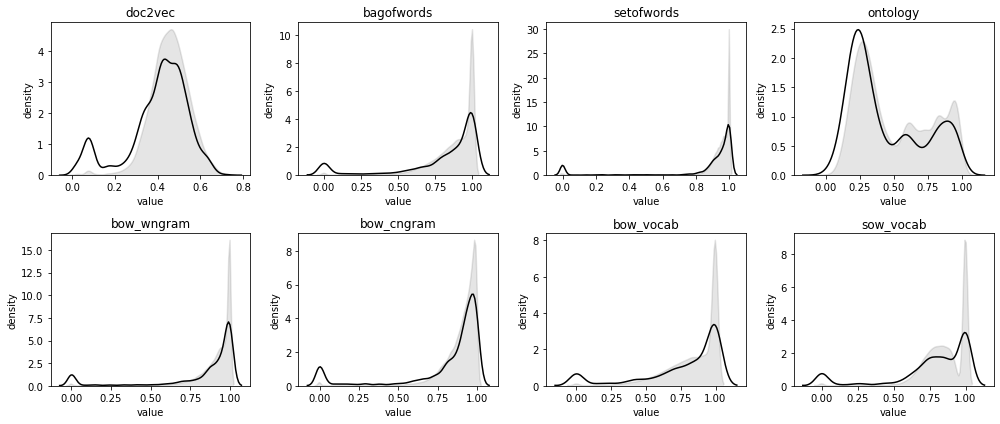

In [11]:
# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = name_to_df_mapping.keys()
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(list)
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method].extend(graph.get_values(within_pairs, kind=method))
        
# Plotting the kernel density estimates of the whole-data and within-group distributions.
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS,axs.flatten()):
    ax.set_title(method)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(within_weights_dict[method], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(all_weights_dict[method], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### Which biochemical pathways are the most 'phenotypically visible' in this dataset?

In [13]:
# Same thing but keeping track of means for each specific pathway or grouping with nested dict.

# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = name_to_df_mapping.keys()
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method][group] = np.mean((graph.get_values(within_pairs, kind=method)))

In [14]:
# Find the average rank of each pathway or group in terms of how low the mean within-group distance values were.
ranks = pd.DataFrame(within_weights_dict).rank()
ranks["average"] = ranks.mean(axis=1)
ranks.sort_values(by="average", inplace=True)


ranks.reset_index(inplace=True)
ranks["group_id"] = ranks["index"]
ranks["full_name"] = ranks["group_id"].apply(lambda x: groups.get_long_name(x))
ranks = ranks[["average","full_name"]]
print(ranks.head(10))



#means_df = pd.DataFrame(within_weights_dict)
#means_df.reset_index(inplace=True)
#means_df["name"] = means_df["index"].apply(lambda x: groups.get_long_name(x))

# need to add the values of n to this dataframe for each?




#means_df.sort_values(by=["doc2vec"], inplace=True)
#means_df["rank"] = means_df["doc2vec"].rank()
#print(means_df.head(20))









   average                                          full_name
0   2.0625                          neurosporene biosynthesis
1   5.5000                     caffeoylglucarate biosynthesis
2   6.6250                                lutein biosynthesis
3   6.6250                            zeaxanthin biosynthesis
4   9.3750  UDP-&alpha;-D-galacturonate biosynthesis I (fr...
5  11.7500                                 UMP biosynthesis I
6  11.7500        L-arginine biosynthesis I (via L-ornithine)
7  19.0000                              olivetol biosynthesis
8  19.0000                           resveratrol biosynthesis
9  26.0000                           L-histidine biosynthesis


### Predicting whether two genes share or do not share a functional classification or pathway

In [15]:
# Generate the targe class values, 1 indicating common function and 0 indicating no common function.
df.loc[:,"class"] = [int(len(set(id_to_group_ids[id1]).intersection(set(id_to_group_ids[id2])))>0) 
    for (id1,id2) in zip(df["from"].values,df["to"].values)]
print(df.head(8))

   from     to   doc2vec  bagofwords  setofwords  ontology  bow_wngram  bow_cngram  bow_vocab  sow_vocab  class
1   740   3205  0.379535         1.0         1.0  0.890000         1.0    0.960965        1.0        1.0      0
2   740    302  0.504822         1.0         1.0  0.816514         1.0    0.964336        1.0        1.0      0
3   740   8243  0.420297         1.0         1.0  0.735849         1.0    1.000000        1.0        1.0      0
4   740   2161  0.616142         1.0         1.0  0.892562         1.0    0.978064        1.0        1.0      0
5   740   1724  0.404003         1.0         1.0  0.804878         1.0    1.000000        1.0        1.0      1
6   740   2648  0.574573         1.0         1.0  0.657143         1.0    0.996363        1.0        1.0      0
7   740   3259  0.456270         1.0         1.0  0.881081         1.0    0.996095        1.0        1.0      0
8   740  16615  0.528227         1.0         1.0  1.000000         1.0    0.983509        1.0        1.0

               auc baseline n_shared  n_not
doc2vec     0.0558   0.0245     1955  77845
bagofwords  0.0592   0.0245     1955  77845
setofwords  0.0646   0.0245     1955  77845
ontology    0.0339   0.0245     1955  77845
bow_wngram  0.0541   0.0245     1955  77845
bow_cngram  0.0603   0.0245     1955  77845
bow_vocab   0.0524   0.0245     1955  77845
sow_vocab   0.0549   0.0245     1955  77845


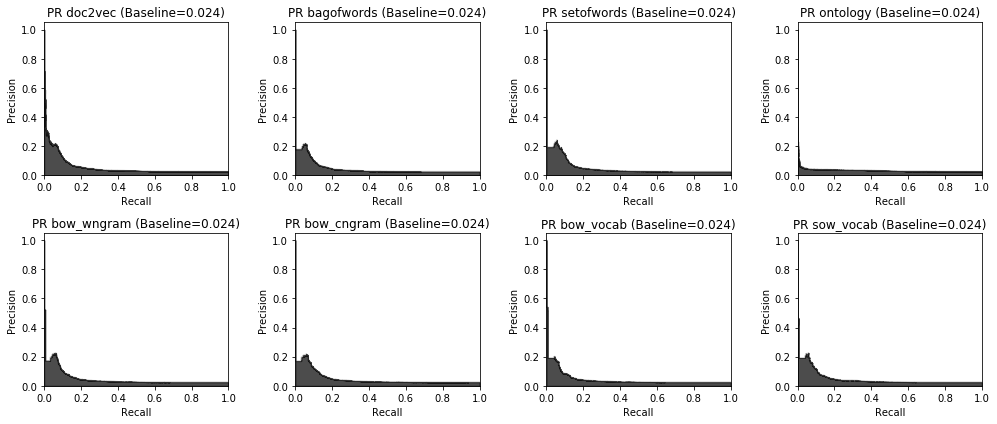

In [16]:
y_true_dict = {name:df["class"] for name in METHODS}
y_prob_dict = {name:(1 - df[name].values) for name in METHODS}
results = {}

num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS, axs.flatten()):
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[method] = {"auc":"{:.4f}".format(area), 
                       "baseline":"{:.4f}".format(baseline), 
                       "n_shared":"{:.0f}".format(n_pos), 
                       "n_not":"{:.0f}".format(n_neg)}
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
print(pd.DataFrame(results).transpose())
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### Predicting which functional group or pathway a specific gene belongs to

In [ ]:
# Can we learn associations between biochemical pathways and text descriptions?
# The non ml ways of doing this would be:
#    1 create a representative datapoint for each pathway by first dropping the specific sample then mapping.
#    need to implement a function for dropping k samples from the matrix calculation and then classifying them?
#    2 just use the mean similarity to other members of that thing.
#    3 The thing 